<a href="https://colab.research.google.com/github/fangoner/gittest/blob/master/OPC_Text_Mining_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [0]:
!nvidia-smi

Thu Dec 26 10:53:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q torch torchvision feather-format kornia pyarrow Pillow wandb nbdev fastprogress --upgrade 
!pip install -q git+https://github.com/fastai/fastcore  --upgrade
!pip install -q git+https://github.com/fastai/fastai2 --upgrade

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *

In [0]:
def predict(learn, item, rm_type_tfms=0):
  dl = test_dl(dbunch, item, rm_type_tfms=rm_type_tfms)
  inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
  i = getattr(dbunch, 'n_inp', -1)
  full_dec = dbunch.decode_batch((*tuplify(inp),*tuplify(dec_preds)))[0][i:]
  return detuplify(full_dec),dec_preds[0],preds[0]

# Data Prep

First we get our data and tokenize it.

In [0]:
path = Path("/content/drive/My Drive/OPC Text Mining")

In [0]:
df = pd.read_csv(path/'OPC Text Mining Processed.csv')

In [0]:
df.drop(df[df.text == '#NAME?'].index, inplace=True)

Then we put it in a `DataSource`. For a language model, we don't have targets, so there is only one transform to numericalize the texts. Note that `tokenize_df` returns the count of the words in the corpus to make it easy to create a vocabulary.

In [0]:
df_tok,count = tokenize_df(df, 'text')
vocab = make_vocab(count)

#Training a LM model

In [0]:
#df_tok.to_csv(path/"full_tok.csv")
#pd.DataFrame({"vocab":vocab}).to_csv(path/"vocab.csv")
#splits = RandomSplitter()(range_of(df_tok))

In [0]:
splits = (L(list(pd.read_csv(path/"train_ids.csv").ids)), L(list(pd.read_csv(path/"valid_ids.csv").ids)))

In [0]:
dsrc = DataSource(df_tok, [[attrgetter("text"), Numericalize(vocab)]], splits=splits, dl_type=LMDataLoader)

Then we use that `DataSource` to create a `DataBunch`. Here the class of `TfmdDL` we need to use is `LMDataLoader` which will concatenate all the texts in a source (with a shuffle at each epoch for the training set), split it in `bs` chunks then read continuously through it.

In [0]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True),),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter())

In [0]:
dbunch = dblock.databunch(df_tok)

In [0]:
dbunch = dsrc.databunch(bs=128, seq_len=72, after_batch=Cuda)

In [0]:
dbunch.show_batch()

,text,text_
0,"xxbos xxmaj the safety department is manned by thirty five persons including the department manager , supervisor , and xxup sb operators . xxmaj the department conducts random audits and inspections at will , addressing staff and contractors . xxmaj non compliance of policies results in severe penalties . \r\n\r\n xxmaj the audit function is considered not very effective . xxmaj this is supported by the poor housekeeping found in some areas","xxmaj the safety department is manned by thirty five persons including the department manager , supervisor , and xxup sb operators . xxmaj the department conducts random audits and inspections at will , addressing staff and contractors . xxmaj non compliance of policies results in severe penalties . \r\n\r\n xxmaj the audit function is considered not very effective . xxmaj this is supported by the poor housekeeping found in some areas ."
1,". xxmaj no major production loss is expected , \r\n as this feedstock is not critical . xxmaj alternatively , the refinery could purchase xxmaj gas xxmaj oil in the spot \r\n market ( typically from xxmaj peru and xxmaj equator ) . \r\n\r\n c ) xxmaj naphtha : \r\n\r\n xxmaj naphtha is normally supplied from xxup enap xxmaj magallanes xxmaj refinery . xxmaj on average , there is a small \r\n","xxmaj no major production loss is expected , \r\n as this feedstock is not critical . xxmaj alternatively , the refinery could purchase xxmaj gas xxmaj oil in the spot \r\n market ( typically from xxmaj peru and xxmaj equator ) . \r\n\r\n c ) xxmaj naphtha : \r\n\r\n xxmaj naphtha is normally supplied from xxup enap xxmaj magallanes xxmaj refinery . xxmaj on average , there is a small \r\n consumption"
2,the xxup mcc buildings are equipped with smoke detectors . \r\n xxmaj windsocks are also available to monitor atmospheric conditions in the event of a hazardous material release . \r\n\r\n xxmaj there is a good level of flammable and toxic gas detection in the various process plants . xxmaj gas detection panels are located in each control room and provide a clear indication as to the location of any gas release .,xxup mcc buildings are equipped with smoke detectors . \r\n xxmaj windsocks are also available to monitor atmospheric conditions in the event of a hazardous material release . \r\n\r\n xxmaj there is a good level of flammable and toxic gas detection in the various process plants . xxmaj gas detection panels are located in each control room and provide a clear indication as to the location of any gas release . xxmaj
3,"welded or have welded flanged fittings conforming to applicable xxup ansi / xxup asme standards ( e.g. , xxup ansi / xxup asme xxup b31.1 , xxmaj power xxmaj piping , xxup ansi / xxup asme xxup xxunk , factory - made xxmaj xxunk xxmaj steel xxmaj xxunk xxmaj fittings , and xxup ansi / xxup asme xxup xxunk , xxmaj xxunk xxmaj ends ) or international equivalents . xxmaj piping 2-inch","or have welded flanged fittings conforming to applicable xxup ansi / xxup asme standards ( e.g. , xxup ansi / xxup asme xxup b31.1 , xxmaj power xxmaj piping , xxup ansi / xxup asme xxup xxunk , factory - made xxmaj xxunk xxmaj steel xxmaj xxunk xxmaj fittings , and xxup ansi / xxup asme xxup xxunk , xxmaj xxunk xxmaj ends ) or international equivalents . xxmaj piping 2-inch or"
4,dike area . \r\n xxmaj housekeeping in some of the process units ( especially # 2 xxup cdu ) was not good . \r\n xxmaj drains were covered with rubber sheets . xxbos xxmaj this element was not discussed in details and this there is no update on this element from this year 's survey . xxmaj the situation is considered not to change much from the last risk visit . xxmaj,area . \r\n xxmaj housekeeping in some of the process units ( especially # 2 xxup cdu ) was not good . \r\n xxmaj drains were covered with rubber sheets . xxbos xxmaj this element was not discussed in details and this there is no update on this element from this year 's survey . xxmaj the situation is cons

Then we have a convenience method to directly grab a `Learner` from it, using the `AWD_LSTM` architecture.

In [0]:
learn = language_model_learner(dbunch, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.1, path=path, opt_func = partial(Adam, wd=0.1)).to_fp16()

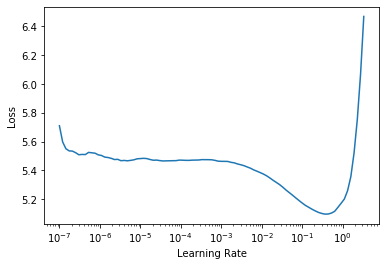

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-2, moms=(0.95,0.85,0.95)) #drop=0.1, wd=0.1, bs = 128, moms=(0.95,0.85,0.95)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.569062,3.405369,0.356771,30.125397,07:56
1,3.384570,3.262715,0.370260,26.120348,07:55
2,3.262702,3.188183,0.379237,24.244326,07:57
3,3.166873,3.142808,0.385649,23.168833,07:55
4,3.106172,3.133543,0.387122,22.955166,07:56


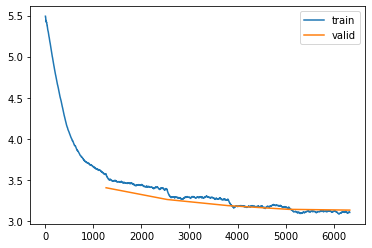

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/'fine_tuned_opt')
learn.save_encoder(path/'fine_tuned_enc_opt')

In [0]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7,0.8)) #drop=0.1, wd=0.1, bs = 128

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.566092,3.408560,0.355700,30.221687,07:59
1,3.379266,3.263129,0.369755,26.131168,08:00
2,3.267337,3.189065,0.378846,24.265728,07:57
3,3.168041,3.143443,0.385494,23.183542,07:59
4,3.114200,3.133576,0.387009,22.955933,07:55


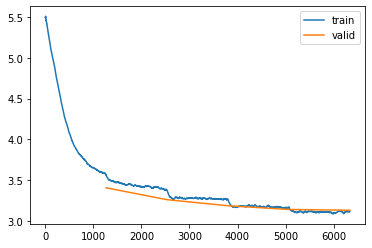

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7,0.8)) #drop=0.5, wd=0.1, bs = 128

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.752517,3.446183,0.351555,31.380377,07:57
1,3.592467,3.314965,0.363006,27.521418,07:58
2,3.492496,3.244467,0.371121,25.648037,07:57
3,3.415489,3.198991,0.376828,24.507792,07:58
4,3.372194,3.188281,0.378389,24.246719,07:57


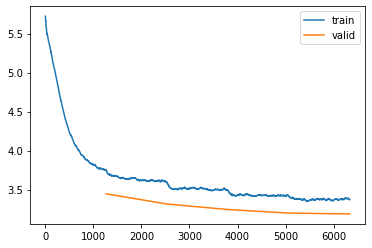

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7,0.8)) #drop=0.3, wd=0.1

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.655045,3.427626,0.354214,30.803417,07:32
1,3.498872,3.286511,0.367157,26.749384,07:28
2,3.377561,3.214359,0.375349,24.887329,07:33
3,3.290834,3.169030,0.381337,23.784395,07:32
4,3.256945,3.158427,0.382895,23.533560,07:28


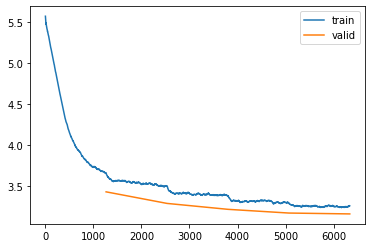

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7,0.8)) #drop=0.5

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7,0.8)) #drop=0.3, wd=0.1

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.106472,3.059677,0.396070,21.320667,08:31
1,3.034454,2.965001,0.408899,19.394716,08:31
2,2.906126,2.887239,0.421028,17.943693,08:28
3,2.813708,2.826227,0.432068,16.881645,08:24
4,2.728525,2.780508,0.440711,16.127216,08:27
5,2.651672,2.743846,0.448435,15.546659,08:25
6,2.596861,2.719663,0.453814,15.175213,08:26
7,2.517169,2.702800,0.457289,14.921447,08:23
8,2.504031,2.697648,0.458760,14.844780,08:22
9,2.475933,2.697805,0.459023,14.847113,08:23


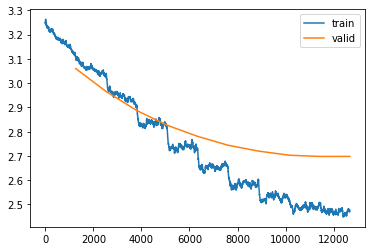

In [0]:
learn.recorder.plot_loss()

Once we have fine-tuned the pretrained language model to this corpus, we save the encoder since we will use it for the classifier.

In [0]:
learn.show_results()

,input,target,pred
0,"xxbos 18 firewater hydrants , 5 firewater monitors , 19 foam monitors and 20 foam hose reels are distributed across the site . \r\n xxmaj majority of the foam monitors are distributed around the xxup hp separators , flash gas separators and condensate storage areas where there are significant inventories of flammable hydrocarbons with low flash points . \r\n xxmaj hydrants , monitors and hose reels are provided at strategic locations of","18 firewater hydrants , 5 firewater monitors , 19 foam monitors and 20 foam hose reels are distributed across the site . \r\n xxmaj majority of the foam monitors are distributed around the xxup hp separators , flash gas separators and condensate storage areas where there are significant inventories of flammable hydrocarbons with low flash points . \r\n xxmaj hydrants , monitors and hose reels are provided at strategic locations of non","xxmaj - pumps , 10 monitors monitors and and fixed monitors , a hose monitors reels xxbos distributed throughout the site . xxmaj xxmaj there of the fire systems are located around the site lng and and xxup gas separators , condensate storage tanks . there are large inventories of xxup liquids . a flash point . \r\n xxmaj there are monitors and deluge reels are distributed throughout strategic locations throughout the"
1,"although hydrants are installed at this grid , according to the fire brigade , this system is not used for manual fire fighting . \r\n xxmaj the main water system is a combined system for process water ( mainly cooling ) and for fire fighting . xxmaj this , so called xxup k2 system , is fed by 4 electrically driven pumps and one diesel driven pump ( 8 . xxrep 3","hydrants are installed at this grid , according to the fire brigade , this system is not used for manual fire fighting . \r\n xxmaj the main water system is a combined system for process water ( mainly cooling ) and for fire fighting . xxmaj this , so called xxup k2 system , is fed by 4 electrically driven pumps and one diesel driven pump ( 8 . xxrep 3 0","the are installed at the site , there to the information protection , the is is not used for fire fire fighting . xxmaj xxmaj the fire fire supply is supplied ring system of the and and xxunk for ) and for fire fighting . xxmaj the system together called "" xxunk system , is used by two x driven pumps ( 1 electric driven pump ( xxunk , xxrep 3 0"
2,"docks . xxmaj some flooding has also been experienced in the northern half of the refinery tank farm . \r\n\r\n xxmaj rating raised from "" medium "" to "" medium - high "" . xxbos xxmaj hazop for new xxunk \r\n xxmaj plant modifications are not xxup hazoped . xxbos xxmaj the supply of fire water is more than sufficient as the system has been designed for a large refinery including a",". xxmaj some flooding has also been experienced in the northern half of the refinery tank farm . \r\n\r\n xxmaj rating raised from "" medium "" to "" medium - high "" . xxbos xxmaj hazop for new xxunk \r\n xxmaj plant modifications are not xxup hazoped . xxbos xxmaj the supply of fire water is more than sufficient as the system has been designed for a large refinery including a tank","and xxmaj the of has been been experienced in the xxmaj part of the refinery . farm . xxmaj xxmaj the raised from "" medium "" to "" medium - high "" . xxbos xxmaj the studies all projects . xxmaj no has are subject covered hazoped . xxbos xxmaj the site of raw water to from than adequate for the refinery is been designed for a fire fire fire the large"
3,"the inspection programmes are a time - based system and they are based on statutory requirements ( steam boilers , air systems ) and xxup api standards and xxup asme xxmaj codes . \r\n\r\n xxmaj according to the xxmaj israeli laws , the statutory requirements comprise the following equipment and entail the respective inspection frequencies : \r\n\r\n - xxmaj lifting equipment : xxunk . \r\n - xxmaj lifting details / ancillary :","inspection programmes

In [0]:
learn.save(path/'fine_tuned')
learn.save_encoder(path/'fine_tuned_enc')

In [0]:
learn.load(path/'fine_tuned')
learn.load_encoder(path/'fine_tuned_enc')

In [0]:
learn.validate()

(#3) [2.697805404663086,0.4590226113796234,14.847112655639648]

In [0]:
input_str = "petrochemical plant is typically high risk industry"

In [0]:
learn.predict(input_str, n_words=50)

'petrochemical plant is typically high risk industry . \r\n Tsunami exposure is contradicting . There are approximately 60 feet of deluge protection provided at the top of the east part of the process . \r\n CHENAL loading stations are fully equipped with hydrants located outside the containers . LPG feedstock is'

#Classification for PE

For classification, we need to use two set of transforms: one to numericalize the texts and the other to encode the labels as categories.

In [0]:
df_pe = df[df["type"] == "PE"]
df_tok, _ = tokenize_df(df_pe, 'text')

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(70283, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
43271,Business continuity management,PE,1,A,20,"[xxbos, xxmaj, good, level, of, spares]"
43272,Business continuity management,PE,1,A,20,"[xxbos, no, info, ,, xxmaj, assumed, ok, .]"
43273,Business continuity management,PE,2,B,20,"[xxbos, xxmaj, no, formal, xxup, bcp, noted, .]"
43274,Housekeeping,PE,1,A,20,"[xxbos, xxmaj, no, issues, mentioned, .]"
43275,Housekeeping,PE,1,A,20,"[xxbos, reported, as, adequate]"


In [0]:
df_cls["comb_rating"] = df_cls.rating + " " + df_cls.label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_cls.head()

,label,type,score,rating,length,text,comb_rating
43271,Business continuity management,PE,1,A,20,"[xxbos, xxmaj, good, level, of, spares]",A Business continuity management
43272,Business continuity management,PE,1,A,20,"[xxbos, no, info, ,, xxmaj, assumed, ok, .]",A Business continuity management
43273,Business continuity management,PE,2,B,20,"[xxbos, xxmaj, no, formal, xxup, bcp, noted, .]",B Business continuity management
43274,Housekeeping,PE,1,A,20,"[xxbos, xxmaj, no, issues, mentioned, .]",A Housekeeping
43275,Housekeeping,PE,1,A,20,"[xxbos, reported, as, adequate]",A Housekeeping


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#56227) [48250,28269,56168,48672,40482,31721,61457,25116,36183,38638...],
 (#14056) [3427,67594,43808,18388,31042,51439,6104,69851,58367,24169...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("comb_rating"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj the xxup pptsb / xxup amsb fire protection is based around a firewater ring main , supplying water to fire hydrants , water monitors \r\n and deluge / sprinkler systems on the entire site . xxmaj the system has been installed to protect the process units and consists of a ring main of varying diameters ( 14 ” , 12 ” and 8 ” ) ; and is installed underground . xxmaj isolation valves have been installed \r\n throughout this network to ensure that all areas can be provided with firewater if a pipe section fails or is out of service for maintenance . \r\n xxmaj there are three firewater pump stations / areas on the facility , each with a collection of pumps . xxmaj firewater pump area 1 has three main pumps , where one is electrical driven and the other two are diesel driven .",A Fire water supply
1,"xxbos 2015b : \r\n 2012.04 = > xxmaj firewater capacity \r\n a new firewater station was constructed in 2014 and two main fire pumps were added . xxmaj these are tied into the existing fire - water main . xxmaj so , the total floor rate of all fire pumps at this site is some 5,600 m3 . \r\n\r\n 2006 - 7 xxmaj fire xxmaj protection xxmaj floating xxmaj roof xxmaj storage xxmaj tanks = > xxmaj at present no fire pre - plans exist on full surface tank fires . xxmaj the site also does not have any high capacity monitors , nor adequate foam supplies , to fight this type of fire . = > xxup stc has improved as follows : -sop improvement , -calculation of the amount of foam agent to be taken . -purchasing of foam trailer = > xxmaj retain b \r\n\r\n xxmaj there",B Fire water supply


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

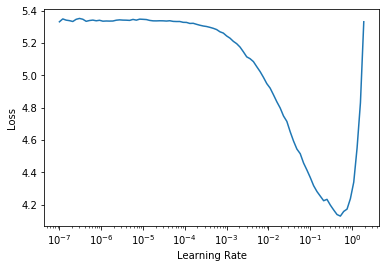

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.493493,1.405429,0.573776,02:38
1,1.416781,1.298088,0.584306,02:40
2,1.282568,1.200111,0.608281,02:39
3,1.166976,1.176930,0.614471,02:40
4,1.080879,1.158198,0.620447,02:39


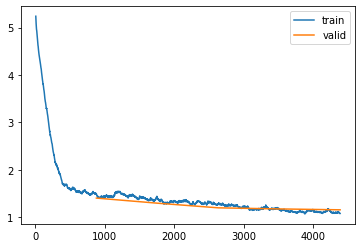

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.137090,1.159423,0.621087,02:37
1,1.160268,1.163870,0.620091,02:37
2,1.117087,1.172437,0.614328,02:39
3,1.021978,1.185480,0.611198,02:38
4,1.069714,1.163426,0.619878,02:40


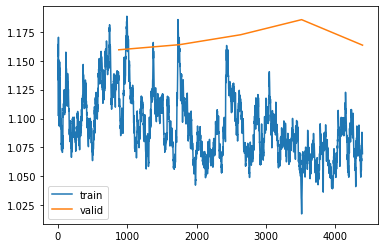

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.995745,1.129400,0.631901,04:01
1,0.848119,1.098526,0.648193,04:01
2,0.713886,1.099732,0.661141,04:03
3,0.578731,1.109202,0.662564,04:02
4,0.531201,1.121289,0.661639,04:01


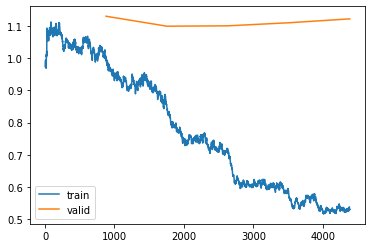

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first")

In [0]:
learn.load(path/"first")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxmaj the xxup pptsb / xxup amsb fire protection is based around a firewater ring main , supplying water to fire hydrants , water monitors \r\n and deluge / sprinkler systems on the entire site . xxmaj the system has been installed to protect the process units and consists of a ring main of varying diameters ( 14 ” , 12 ” and 8 ” ) ; and is installed underground . xxmaj isolation valves have been installed \r\n throughout this network to ensure that all areas can be provided with firewater if a pipe section fails or is out of service for maintenance . \r\n xxmaj there are three firewater pump stations / areas on the facility , each with a collection of pumps . xxmaj firewater pump area 1 has three main pumps , where one is electrical driven and the other two are diesel driven .",A Fire water supply,A Fire water supply
1,"xxbos xxmaj manning : \r\n xxmaj aromatics - 14 per shift x 4 shifts . \r\n xxmaj condensate - 8 per shift x 4 shifts . \r\n xxmaj oil movement - 7 per shift x 4 shifts . \r\n\r\n xxmaj experience : \r\n xxmaj board men mostly have 7 - 8 years experience . xxmaj the least is 4 - 5 years . xxmaj some of them have > 20 years . xxmaj supervisor level has about 13 - 15 years experience . \r\n\r\n xxmaj there are many new recruits for operators with mostly one year experience and maximum 3 years experience . xxmaj in the last one year , the priority was to keep the key shift supervisors , key boardman , and key technicians . \r\n\r\n xxmaj there were some key people leaving xxmaj condensate section . xxup jac is getting some people from xxmaj philippines with aromatic","B Manning, training and experience","A Manning, training and experience"
2,"xxbos xxunk . xxmaj review xxmaj fire xxmaj water xxmaj requirements in line with xxup rpi xxmaj report = > there is a deficiency in the fire water available versus that required to tackle a full surface fire on xxmaj tank 004 ( 80 , xxrep 3 0 m3 crude oil tank ) . = > 2013 xxup update - xxup in xxup progress . \r\n\r\n xxmaj the refinery is serviced with a fire water main , consisting of three interconnected ring mains . xxmaj one ring services the south tank farm , one ring the xxmaj north process area , and the third ring services the xxmaj south process area . xxmaj isolation valves are located to allow feeding from two directions simultaneously or xxunk , if required . \r\n xxmaj there are several fire water sources . a 12,700 m3 water tank is provided to feed three 500",A Fire water supply,A Fire water supply
3,"xxbos 2013 : \r\n xxmaj reco 12.02 xxmaj fireproof xxmaj pipe xxmaj supports on xxup fcc xxup mcb piping / xxup rd4 / xxup vdu ( fp2 ) \r\n xxmaj reco 10.05 xxmaj improve long bolted flange fire protection = > no progress \r\n xxmaj reco 08.02 xxmaj fireproofing of xxmaj column xxmaj skirts = > xxmaj closed = > a significant number of vessel skirts had been fireproofed ( intumescent coating ) inside and outside . xxmaj however , elevated columns on the xxup cdu and xxup fcc were not fireproofed as location says that they would be flooded by foam rings . \r\n\r\n 2010 : xxmaj change from c to xxup b. \r\n xxmaj in the cold section of the xxmaj ethylene unit , fireproofing generally extends to about 8 m above grade to include the first and second horizontals members . xxmaj process vessels are mainly on",B Construction materials of supporting structures and walls,B Construction materials of supporting structures and walls
4,"xxbos xxmaj water for fire protection is supplied by five automatic starting , vertical turbine fire pumps located in two fire pump houses which take suction from a common 2 million gallons fire water pond . xxmaj the pond is kept full by a connection to the xxup basf clarified water system . xxmaj these pumping systems are designed as xxup nfpa 20 installations although three of the pumps , i.e. , 29a , 29b and 30c , do not have labels indicating xxup fm approval or a xxup ul listing . a jockey pump provides

In [0]:
learn.validate()

(#2) [1.1212893724441528,0.6616391539573669]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn_temp, input_df)

('A Gas detection, fire and smoke detection measures',
 tensor(16),
 tensor([1.5167e-09, 2.0651e-07, 1.0507e-06, 3.8557e-09, 2.0613e-07, 1.3770e-07,
         8.1082e-08, 7.3328e-09, 1.3777e-08, 4.1609e-07, 4.8981e-07, 1.2084e-07,
         6.1883e-08, 7.0646e-08, 1.1133e-05, 1.9964e-09, 7.4199e-01, 1.9536e-06,
         1.7794e-08, 2.9305e-06, 5.9246e-07, 9.0916e-08, 2.1569e-08, 2.4600e-09,
         2.7626e-06, 8.4056e-09, 5.7900e-08, 8.6125e-08, 9.0226e-07, 9.1610e-08,
         7.4593e-09, 2.4052e-08, 4.6655e-09, 6.0171e-09, 5.7786e-08, 2.2498e-07,
         9.5946e-10, 4.1850e-09, 6.5799e-08, 3.5280e-10, 1.1667e-06, 6.5182e-07,
         2.0753e-09, 5.8263e-07, 4.6283e-08, 2.9371e-07, 3.7785e-08, 3.2113e-08,
         1.1821e-07, 5.4470e-07, 1.2567e-06, 5.7715e-07, 5.8552e-08, 4.1881e-06,
         2.7617e-08, 2.4113e-01, 4.2742e-07, 8.3446e-08, 4.3666e-07, 3.5975e-07,
         7.1789e-08, 6.9843e-08, 3.9613e-09, 2.4288e-07, 2.0850e-08, 1.7244e-08,
         3.6802e-07, 1.8916e-06, 3.3795e-

In [0]:
input_num = dsrc_temp.tfms[0][1](input_tok).cuda()
pred      = learn_temp.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc_temp.tfms[1][1].decode(pred.argmax()); pred_cat

'A Gas detection, fire and smoke detection measures'

#Classification for PE : label only

In [0]:
df_pe = df[df["type"] == "PE"]
df_tok, _ = tokenize_df(df_pe, 'text')

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(70283, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
43271,Business continuity management,PE,1,A,20,"[xxbos, xxmaj, good, level, of, spares]"
43272,Business continuity management,PE,1,A,20,"[xxbos, no, info, ,, xxmaj, assumed, ok, .]"
43273,Business continuity management,PE,2,B,20,"[xxbos, xxmaj, no, formal, xxup, bcp, noted, .]"
43274,Housekeeping,PE,1,A,20,"[xxbos, xxmaj, no, issues, mentioned, .]"
43275,Housekeeping,PE,1,A,20,"[xxbos, reported, as, adequate]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#56227) [45087,46287,35294,23272,59031,39291,52395,33923,58190,5153...],
 (#14056) [29414,51132,65522,66912,41540,62463,67556,36621,59896,39175...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("label"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj borouge has its own fire brigade under the responsibility of the xxmaj health , xxmaj safety and xxmaj environment xxmaj department ’s xxmaj loss xxmaj prevention xxmaj function . xxmaj fire fighting personnel work on an eight hour shift basis , 24 hours / day under the supervision of the xxmaj fire xxmaj chief ; there are 46 xxmaj fire and xxmaj rescue personnel in this team , including 4 xxmaj shift xxmaj supervisors , 8 xxmaj assistant xxmaj shift xxmaj supervisors , 24 xxmaj attendants and 5 xxmaj fire xxmaj control xxmaj panel xxmaj operators . xxmaj in addition to each shift there is assistance available from up to 15 trained xxmaj emergency xxmaj response xxmaj team ( ert ) members on site , recruited from the xxmaj operations xxmaj department where at least one operator / shift on each unit has been trained . \r\n xxmaj",Fire brigade and public fire department
1,"xxbos xxmaj jetty \r\n xxmaj the xxmaj port xxmaj arthur xxmaj terminal , two miles south of the site , has three berths , which are used to export products and import intermediates , such as gasoline blend stocks , diesel , fuel oil , xxup vgo and coker feed , and lubes . \r\n\r\n xxmaj the xxmaj port xxmaj arthur xxmaj terminal docks have concrete and steel berths . xxmaj connections use flexible hoses , with insulating flanges provided on the manifold . xxmaj remote isolation facilities are available for all pipelines to the xxmaj terminal . \r\n\r\n xxmaj road and xxmaj rail \r\n xxmaj smaller product quantities are dispatched by road and rail . xxmaj rail facilities are now only used for export of lube oils , petroleum coke , and caustic . \r\n\r\n xxmaj liquid sulfur is loaded into trucks for transport to a terminal in south",Loading / Unloading / Shipping


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

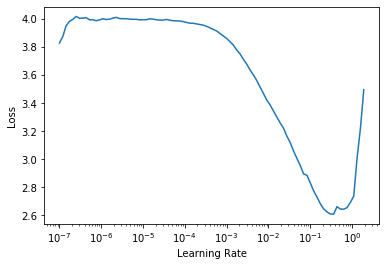

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.576928,0.527601,0.862479,02:37
1,0.606797,0.465131,0.868739,02:37
2,0.504570,0.428176,0.883751,02:36
3,0.461022,0.415026,0.890083,02:37
4,0.469056,0.410647,0.891007,02:38


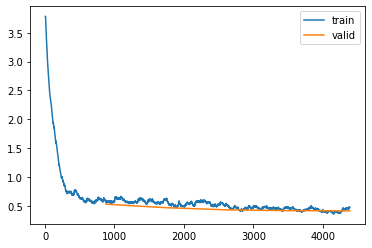

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.420503,0.412335,0.890438,02:39
1,0.415469,0.415191,0.890936,02:38
2,0.390555,0.417033,0.891079,02:37
3,0.426048,0.411608,0.891079,02:35
4,0.406864,0.418043,0.891292,02:35


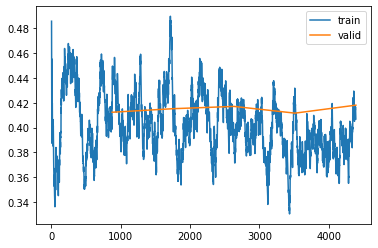

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.342042,0.414694,0.891292,04:04
1,0.241383,0.404084,0.895063,04:02
2,0.157818,0.409705,0.900327,03:59
3,0.113022,0.414364,0.902817,03:57
4,0.118041,0.413612,0.902390,03:58


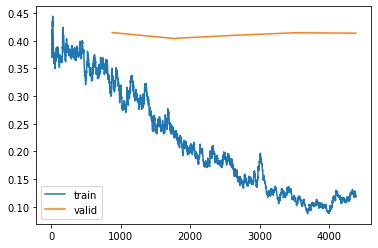

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_pe_label_classification")

In [0]:
learn.load(path/"first_pe_label_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxmaj water spray systems are provided over some of the pump rows but these do not cover all of the higher hazard or limited access pumps . \r\n\r\n xxmaj deluge xxmaj systems : \r\n xxmaj plant \t xxmaj covers \t xxmaj no . of xxmaj systems \r\n xxup t&s \t▁ # 2 xxmaj tank xxmaj farm , xxmaj propane loading \t 1 \r\n\t xxup pp xxmaj rail car rack \t 1 \r\n\t xxunk xxup sph \t 4 \r\n\t xxunk xxup sph \t 4 \r\n\t 4&5 track ( railcars ) \t 2 \r\n xxmaj plant 2 \t xxmaj pumps \t 1 \r\n xxmaj plant 3 \t xxup pp xxmaj bullets \t 2 \r\n\t xxmaj pumps \t 1 \r\n xxmaj plant 4 \t xxmaj pumps \t 3 \r\n xxmaj plant 5 \t xxmaj pumps \t 2 \r\n\t xxup pda ( shut down ) \t 1 \r\n xxmaj plant 6 \t 6",Fixed fire fighting measures,Fixed fire fighting measures
1,"xxbos xxmaj typical of xxmaj india = over designed \r\n\r\n xxmaj as per xxup tac norms for complex falling under xxmaj high xxmaj hazard ( b ) category & as per xxup oisd guidelines , hydrant system are required to be designed to fight two major fires at a time anywhere in the complex and total fire water demand is considered as 7 xxrep 3 0 m3 / hr . \r\n xxmaj individual production unit wise fire water demand is derived ( not verified ) as : \r\n 1 . xxup dfcu = 4700 m3 / hr . \r\n 2 . xxup hgu = 311 m3 / hr . \r\n 3 . xxup pp unit = 2 xxrep 3 0 m3 / hr . \r\n 4 . xxup hdpe / xxup lldpe = 2 xxrep 3 0 m3 / hr . \r\n 5 . xxup hdpe = 2 xxrep 3",Fire water supply,Fire water supply
2,"xxbos 2016 : \r\n 14.05 xxmaj fire xxmaj water xxmaj system xxmaj testing \r\n 2016 status : xxmaj completed . \r\n\r\n xxmaj fire pump performance test is conducted and results are satisfactory . xxmaj fire mains were flushed and tested as well . xxmaj fire pumps are no xxup fm / xxup ul type but overspeed protection is provided ( no xxup prv ) . \r\n\r\n xxmaj shiohama - 2 x 1 , xxrep 3 0 m3 / hr @ 105 m , diesel \r\n xxmaj kawajiri - 2 x 750 m3 / hr @ 100 m , diesel \r\n\r\n xxmaj according to xxup mcc , the maximum fire demand is xxunk m3 / h. xxmaj however , this is based on the regulatory minimum requirement and is not scenario based . xxmaj the demand is to meet xxmaj oil xxmaj complex xxmaj disaster xxmaj prevention xxmaj act , xxmaj",Fire water supply,Fire water supply
3,xxbos xxup hazid \t xxmaj by xxmaj lloyds xxmaj register . xxmaj ship shore xxup hazid . conocophillips participated from xxmaj qatargas side . xxmaj excelerate / xxmaj technica and xxup evtl involvement . \r\n\t\r\n xxup hazop \t xxmaj by xxmaj lloyds xxmaj register xxmaj march 2014 . 37 action items have all been reviewed and implemented where they are design related . a few actions are operational procedures related . xxmaj reviewed by xxmaj marsh at survey . \r\n\t\r\n xxup lopa \t xxmaj by xxmaj lloyds xxmaj register \t\r\n\r\n xxup qra \t xxmaj by xxmaj lloyds xxmaj register xxmaj february 2014 . \t\r\n\r\n xxmaj earthquake \t xxmaj design based on xxmaj zone 2b xxmaj pakistan xxmaj building xxmaj code 2007 with ground acceleration 0.2 g . \t\r\n xxmaj jetty \t xxmaj technica has reviewed all the drawings of xxmaj china xxmaj harbour and have applied a xxup xxunk stress,Process hazards analysis,Process hazards analysis
4,xxbos xxmaj from 2009 - 2010 xxmaj submission : \r\n xxmaj two xxmaj scheduled xxmaj train xxmaj shutdowns \r\n • a - train : xxmaj half xxmaj plant xxmaj turnaround 11 days xxmaj gas to xxmaj gas - ( 6 / 01 / 09 - 6 / 09 / 09 ) \t▁\r\n • b - train : xxmaj half xxmaj plant xxmaj turnaround 21 days xxmaj gas to xxmaj gas - ( 6 / 01 / 09 – 6 / 20 / 09 ) \t▁\r\n • xxmaj brown xxmaj plant xxmaj turnaround 6 days \t\r\n xxmaj one xxmaj scheduled xxmaj extended ‘s ’ xxmaj boiler xxmaj turnaround 30 days ( 7 / 13 / 09 – 8 / 12 / 09 ) \r\n • xxmaj ductwork xxmaj replacement and xxmaj internal xxmaj cleaning \r\n • xxmaj recertification during a - train xxmaj turnaround \r\n xxmaj one xxmaj ammonia xxmaj plant,Maintenance,Maintenance
5,"xxbos a total number of 76 persons form the differ

In [0]:
learn.validate()

(#2) [0.41361209750175476,0.9023904204368591]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

('Gas detection, fire and smoke detection measures',
 tensor(16),
 tensor([3.6882e-11, 2.1240e-08, 1.3421e-09, 5.8899e-11, 7.9012e-10, 3.6890e-10,
         1.0333e-09, 8.5215e-12, 1.5200e-12, 2.3184e-09, 8.0523e-08, 5.6701e-11,
         2.5707e-11, 5.0448e-09, 8.1784e-09, 3.3180e-11, 1.0000e+00, 5.5844e-10,
         1.1552e-08, 7.2147e-08, 7.4004e-08, 3.2860e-09, 5.0383e-11, 8.1444e-11,
         2.0567e-10, 2.1097e-12, 1.2797e-11, 2.2142e-09, 1.0118e-08, 6.7381e-10,
         9.7996e-13, 1.5687e-10, 1.5674e-10, 2.5833e-10, 2.0476e-08, 1.4895e-08,
         7.0157e-12, 8.9887e-11, 9.8189e-09]))

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

'Gas detection, fire and smoke detection measures'

#Classification for PE: rating only

In [0]:
df_pe = df[df["type"] == "PE"]
df_tok, _ = tokenize_df(df_pe, 'text')

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(70283, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
43271,Business continuity management,PE,1,A,20,"[xxbos, xxmaj, good, level, of, spares]"
43272,Business continuity management,PE,1,A,20,"[xxbos, no, info, ,, xxmaj, assumed, ok, .]"
43273,Business continuity management,PE,2,B,20,"[xxbos, xxmaj, no, formal, xxup, bcp, noted, .]"
43274,Housekeeping,PE,1,A,20,"[xxbos, xxmaj, no, issues, mentioned, .]"
43275,Housekeeping,PE,1,A,20,"[xxbos, reported, as, adequate]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#56227) [45087,46287,35294,23272,59031,39291,52395,33923,58190,5153...],
 (#14056) [29414,51132,65522,66912,41540,62463,67556,36621,59896,39175...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("rating"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos 2013 : \r\n 2012.02 xxmaj firewater xxmaj pump xxmaj testing = > actual test result for the last 2 years is 68 % ( i.e. total 8500 gpm ) . xxmaj for design capacity of 10,668 xxup usgpm , all four xxup fw pumps would be required , and still would be inadequate . \r\n xxmaj as xxup p2 demand is low , this is ok . xxmaj changed from xxup aa to a because of pump deficiencies . \r\n\r\n 2011 : \r\n meglobal owns , operates and maintains the firewater and equipment supply system . xxmaj fire water is supplied from the raw water pond , which has a minimum firewater capacity of 6,099,469 usgallons . xxmaj water make - up to this raw water pond is from the xxmaj red xxmaj deer xxmaj river , 12 km away , there are three pumps , each of 350",A
1,"xxbos xxmaj the xxmaj refinery is a long and very narrow 131 acre site . xxmaj the process units are located in small process areas that are well separated from one another . xxmaj there are four distinct process areas : xxmaj crude / xxup dht ; xxmaj platformer / xxmaj unifiner / xxmaj isom ; xxmaj rose / xxup nmp ; and xxup mek xxmaj dewaxing / xxmaj power xxmaj house . a large amount of intermediate product storage tanks are located in and around the process areas . \r\n\r\n xxmaj the xxmaj foster xxmaj brook operations has three separate areas ; the xxmaj crude xxmaj tank xxmaj farm , the xxmaj terminal and the xxmaj packaging xxmaj plant . \r\n\r\n xxmaj process areas have a fairly small foot print with smaller process equipment . xxmaj the layout of the refinery area and the process units within it restrict",B


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

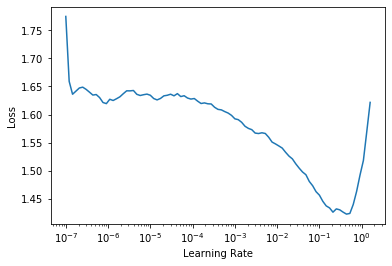

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.896647,0.780458,0.688603,02:38
1,0.852618,0.767470,0.684832,02:35
2,0.826566,0.752611,0.695931,02:32
3,0.765197,0.766339,0.702191,02:30
4,0.779679,0.750977,0.704112,02:34


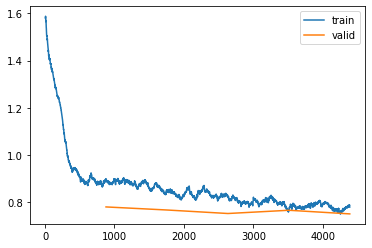

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.778838,0.735019,0.705393,02:37
1,0.779996,0.747927,0.700982,02:38
2,0.759702,0.740839,0.707100,02:35
3,0.764304,0.739638,0.707812,02:37
4,0.739506,0.738388,0.707954,02:34


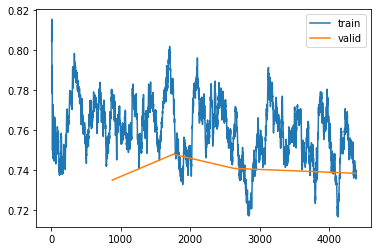

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.688282,0.714550,0.721187,03:55
1,0.570930,0.702497,0.739328,04:03
2,0.467472,0.705160,0.747368,04:05
3,0.375260,0.754114,0.748150,03:55
4,0.339929,0.766142,0.746799,04:00


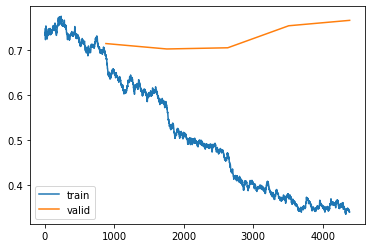

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_pe_rating_classification")

In [0]:
learn.load(path/"first_pe_rating_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxmaj the terminal has a gridded fire main system supplied by five land - based fire pumps spaced around the property . \r\n xxmaj the pumps are each supplied with water from deep wells dedicated to the respective pump . \r\n\r\n\r\n xxmaj main xxmaj terminal \t▁\t▁\t▁\t▁\r\n xxup dp - 3002 \t\t xxmaj diesel \t xxmaj auto \t 2,500 xxup gpm @ 150 psig \t xxmaj deep xxmaj well ( saltwater ) \r\n xxup dp - xxunk \t\t xxmaj diesel \t xxmaj auto \t 2,500 xxup gpm @ 150 psig \t xxmaj deep xxmaj well ( saltwater ) \r\n xxup dp - xxunk * \t\t xxmaj diesel \t xxmaj auto \t 2,500 xxup gpm @ 150 psig \t xxmaj deep xxmaj well ( saltwater ) \r\n xxup dp - xxunk \t\t xxmaj diesel \t xxmaj auto \t 2,500 xxup gpm @ 150 psig \t xxmaj deep xxmaj well ( saltwater",A,A
1,"xxbos 2017 - 3872 : xxmaj per xxmaj chubb : \r\n • xxmaj the operation has been controlled using a xxup dcs . xxmaj for the process safety is used a xxup plc . xxmaj each xxmaj unit has its xxmaj control xxmaj room . \r\n • xxmaj there are ups ’s ( uninterruptible power system ) allowing closing in a safe way the processes during a power shut down . \r\n • xxmaj all the processes are managed from the central panel controls . \r\n • xxmaj there are manual and automatic shutdowns on critical equipment items and unit esds operable from the xxmaj control xxmaj rooms . xxmaj manual esds are hard wired and independent of the xxup dcs . \r\n • xxmaj nevertheless , the inhibitor solution system ( kill system ) for the four xxup pvc reactors has only two trigger ways , which is considered",A,A
2,"xxbos xxup rtfc ( refinery xxmaj terminal xxmaj fire xxmaj company ) is the mutual aid . xxup citgo funds approx . 14 % of the xxup rtfc budget . xxmaj the organization has ~130 trained firefighters located on various company sites and at two central fire stations located in the ship channel area . xxup rtfc provides the xxup citgo refinery with the primary emergency response , providing 16 full - time firefighters , 5 per shift . xxmaj the 5 full time xxup rtfc fire fighters are dedicated to the xxup citgo refinery and can not be called away to another location . xxmaj the emergency response station is located in the xxmaj east xxmaj plant . xxmaj the response time of xxup rtfc is 2 - 3 mins . xxmaj the xxmaj port of xxmaj corpus xxmaj christi maintains a fire barge with tower boom and high",AA,A
3,"xxbos xxmaj raw water supply for fire fighting and plant usage ( excluding potable water ) is obtained from the xxmaj st . xxmaj lawrence xxmaj river . xxmaj there is a 48 inch suction main extending from along the river bottom to the xxmaj dock xxmaj pump xxmaj house . \r\n xxmaj there are two fire pumps ( one 2,500 gpm at 130 psi ( 300 feet head ) diesel and one 2 , xxrep 3 0 gpm at 130 psi steam turbine drive ) which take suction from the 3,250 , xxrep 3 0 xxup us gallon ( 77 , xxrep 3 0 barrel ) tank and one 2,500 gpm at 120 psi ( 276 feet head ) diesel that takes suction from the 600 , xxrep 3 0 gallon cooling tower basin . xxmaj this pump will act as a backup to the previously described two pumps",AA,A
4,"xxbos 2016 : \r\n unchanged , no xxup loto no xxmaj bypass procedure \r\n\r\n 2015 : \r\n 15 - 02 xxmaj liquid xxmaj fuels xxmaj truck xxmaj loading = > safe practices w.r.t . earthing points , isolation valves etc . \r\n 15 - 03 2016 / 7 xxmaj turnaround xxmaj safety \r\n 15 - 06 xxmaj lock xxmaj out / xxmaj tag xxmaj out ( loto ) xxmaj procedure = >  xxmaj there is no formal xxup loto procedure at present .  xxmaj there is no requirement to lock and tag valves which are closed for isolation purposes . = > xxmaj this is a critical issue , the previous 2011 information was then incorrect . = > xxmaj hence changed from a to c \r\n 15 - 07 xxmaj critical xxmaj trip xxmaj bypass xxmaj procedure = > xxmaj the current trip bypass procedure allows trips",C,C
5,"xxbos xxmaj the refinery is accredited to xxup iso 14001 and xxup ohsas 18001 . xxup trir year to date 

In [0]:
learn.validate()

(#2) [0.7661422491073608,0.7467985153198242]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

('A', tensor(0), tensor([9.5829e-01, 4.1379e-02, 3.3396e-04, 3.3364e-08]))

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

'A'

#Classification for RE : label only

In [0]:
df_re = df[df["type"] == "RE"]
df_tok, _ = tokenize_df(df_re, 'text')

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(70283, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
43271,Business continuity management,PE,1,A,20,"[xxbos, xxmaj, good, level, of, spares]"
43272,Business continuity management,PE,1,A,20,"[xxbos, no, info, ,, xxmaj, assumed, ok, .]"
43273,Business continuity management,PE,2,B,20,"[xxbos, xxmaj, no, formal, xxup, bcp, noted, .]"
43274,Housekeeping,PE,1,A,20,"[xxbos, xxmaj, no, issues, mentioned, .]"
43275,Housekeeping,PE,1,A,20,"[xxbos, reported, as, adequate]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#31685) [18737,23416,7124,5012,36144,5007,13902,15094,18403,7430...],
 (#7921) [4048,36066,19747,21043,39084,3292,3437,27268,23870,12645...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("label"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos 2010 : \r\n xxmaj since xxup stc sold on - site utility facilities to the third parties in 1 xxrep 3 9 , xxup stc receives steam and electricity from xxmaj westsea xxmaj power . xxmaj compressed air , nitrogen and oxygen are supplied by xxmaj linde . xxmaj water is supplied from xxmaj westsea xxmaj water . \r\n xxmaj electricity : xxmaj westsea has an on - site generation capacity of 92 xxup mw , which can supply about 75 % of the stc ’s maximum demand . xxmaj electricity is also received from xxup kepco at 154 kv on two overhead lines . \r\n xxmaj the purchased power supplies the xxup lldpe , xxup c4 / xxup btx , xxup hdpe and xxup ldpe plant . xxmaj the site power supplies the others plants and general areas . xxmaj the xxup pp plant and the xxup sm",Utilities/service interruption
1,"xxbos xxmaj inspection xxmaj philosophy \r\n xxmaj the inspection of all pressure vessels is covered by the xxmaj spanish “ reglamento de xxmaj aparatos a xxmaj presión ” ( rap ) legislation . \r\n xxmaj new legislation on piping came into force in 2009 ( itc xxup ep-3 ) . \r\n xxmaj the site implements a time based inspection programme , which reflects xxmaj spanish legislation , modified based on experience . \r\n xxup cepsa intends to introduce xxmaj risk xxmaj based xxmaj inspection ( rbi ) on its chemical sites in 2011 to supplement the existing arrangements . xxup rbi has already been implemented across the xxup cepsa refineries . \r\n xxmaj statutory inspections also include steam boilers and lifting equipment . xxmaj these are carried out by an authorised external agency . \r\n\r\n xxmaj refer mail below : \r\n xxmaj from : \t xxmaj salvatore lomanto / swissre",Inspection regulatory environment


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

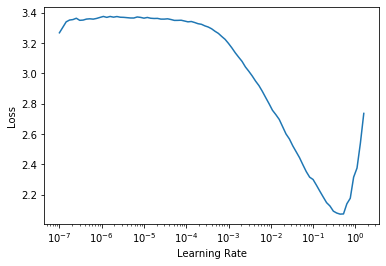

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.634213,0.581576,0.819467,01:21
1,0.552194,0.472232,0.856963,01:20
2,0.464292,0.433464,0.872365,01:21
3,0.404567,0.401944,0.880571,01:20
4,0.402841,0.384068,0.885368,01:20


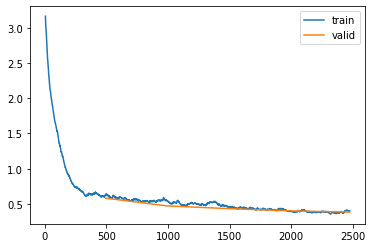

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.355647,0.394873,0.885494,01:20
1,0.346306,0.391184,0.888777,01:19
2,0.350747,0.396840,0.886252,01:19
3,0.340272,0.391822,0.888524,01:19
4,0.351912,0.390307,0.888903,01:19


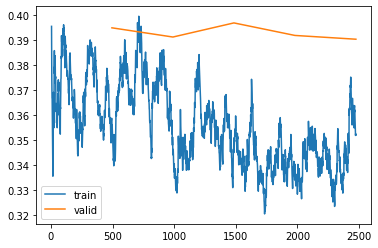

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.322150,0.394737,0.883601,01:52
1,0.222885,0.377188,0.891428,01:51
2,0.140114,0.373890,0.899508,01:51
3,0.109925,0.376386,0.900896,01:52
4,0.094836,0.371389,0.902033,01:50


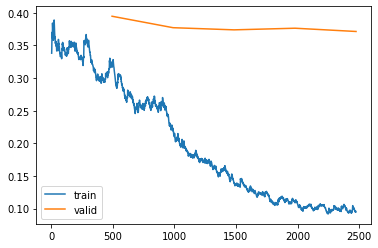

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_re_label_classification")

In [0]:
learn.load(path/"first_re_label_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxmaj the capacities of the different plants are as per the table below : \r\n\r\n\r\n xxmaj units \t xxmaj max xxmaj rate \t xxmaj units \t▁\t xxmaj total xxmaj capacity per xxmaj year \t xxmaj operating xxmaj days xxunk klbs / yr \t▁\r\n xxmaj acetylene \t 175 \t xxunk \t▁\t xxunk \t 330 \r\n xxmaj aniline 1 \t 339 \t xxmaj mtons \t▁\t xxunk \t 330 \r\n xxmaj aniline 2 \t 427 \t xxmaj mtons \t▁\t▁\t 330 \r\n xxup bd \t 440 \t xxmaj mtons \t▁\t xxunk \t 330 \r\n xxup ccu xxunk 330 \r\n xxup dnt \t 766 \t xxmaj mtons \t▁\t xxunk \t 330 \r\n xxup eo \t 696 \t xxmaj mtons \t▁\t xxunk \t 330 \r\n xxup gbl \t 130 \t xxmaj mtons \t▁\t xxunk \t 330 \r\n xxmaj glyoxal \t 125 , xxrep 3 0 \t lbs / day \t▁\t xxunk \t 330 \r\n xxup",Capacity,Capacity
1,"xxbos xxmaj the plant is divided into four main processing areas : \r\n\r\n • \t xxup hf alkylation unit : 90 , xxrep 3 0 t / y are produced in a continuous process . xxmaj as soon as the 15 , xxrep 3 0 t / y pilot plant ( start - up 2005 ) is in operation , the output in this "" old "" alkylation unit will be reduced to 75 , xxrep 3 0 t / y : however overall production will remain at 90 , xxrep 3 0 t / y. xxmaj the xxup hf alkylation plant is of strategic importance to xxmaj chevron xxmaj oronite as it is the only one in the group . xxmaj it has been noted that alternative technologies are being considered to back up the alkylation process . xxmaj the xxup hf alkylation plant mainly produces the following main",Capacity,Capacity
2,"xxbos conocophillips is a xxunk % joint venture partner in the bayu - undan xxmaj offshore xxmaj development xxmaj project , which supplies 100 % of the gas feed to the xxmaj darwin plant . xxmaj the bayu - undan field is located in the xxmaj timor xxmaj sea , approximately 250 km ( 155 mi ) southeast of xxmaj xxunk , timor - xxunk ( see xxmaj figure 3 ) . a 26-inch 500 km ( 310 mi ) sub - sea pipeline delivers dry natural gas from the bayu - undan production facilities to the plant . \r\n\r\n xxmaj the upstream xxmaj business xxmaj interruption xxmaj interdependency ( bii ) exposures at xxmaj darwin are significant . xxmaj the bayu - undan xxmaj offshore xxmaj development xxmaj project supplies 100 % of the natural gas feed to the xxmaj darwin plant ( ~750 mmscfd ) through a 500",Raw materials and products,Raw materials and products
3,"xxbos xxmaj power needed is produced by a 5 xxup mw steam turbine for a total plant requirement of 3 xxup mw at full production capacity . \r\n xxmaj the turbine is critical to the site but not spared . \r\n xxup csar is planning to sell the residual 2 xxup mw to the city of xxmaj san xxmaj antonio in the future . \r\n xxmaj the refinery is on the dead end of the national grid , but is not double ended , so that it can also operate on imported power . \r\n\r\n xxmaj steam : xxmaj the refinery has one fired boiler and one waste heat boiler which can not be shut down without shutting down the crude unit . \r\n xxmaj the xxmaj burner xxmaj control xxmaj system ( bcs ) has been upgraded to a xxup dcs system so that the fuel gas air ratio",Utilities/service interruption,Utilities/service interruption
4,"xxbos xxmaj power : \r\n xxmaj at present , electrical power is supplied by the xxup tu xxmaj electric xxmaj company via two independent 138 xxup kv power lines . xxmaj the electrical system has been upgraded for increased reliability . xxmaj the most significant upgrade was the installation of two new 31 xxup mva transformers . xxmaj these transformers enabled the refinery to be supplied directly from the 138 xxup kv power company ( txu ) grid . xxmaj typical load on the new transformers is 24 xxup mva , and one transformer is a spare . xxmaj substations have been upgraded over the years . pcb - containing equipment was replaced in the past . \r\n\r\n xxmaj steam : \r\n xxmaj nine process waste heat boilers supply some of the refinery ’s steam requirements . \r\n xxmaj there are four fired boilers :

In [0]:
learn.validate()

(#2) [0.3713890612125397,0.9020325541496277]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

NameError: ignored

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

NameError: ignored

#Classification for RE: rating only

In [0]:
df_re = df[df["type"] == "RE"]
df_tok, _ = tokenize_df(df_re, 'text')

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(39606, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
1575,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, stream, plant, .]"
1576,Process flow configuration,RE,3,Medium-High,20,"[xxbos, xxmaj, single, train, process]"
1577,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, totally, single, train]"
1578,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, xxup, cdu, ,, xxup, vdu, ,, xxup, fcc]"
1579,Process flow configuration,RE,1,Low-Medium,20,"[xxbos, xxmaj, two, processing, units]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#31685) [18737,23416,7124,5012,36144,5007,13902,15094,18403,7430...],
 (#7921) [4048,36066,19747,21043,39084,3292,3437,27268,23870,12645...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("rating"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos 2014 : \r\n xxmaj there is no change in the rating . \r\n xxmaj the location comprises of a xxmaj naphtha xxmaj cracker with several downstream polymer plants ( ldpe , xxup pp , xxup btx etc . ) \r\n\r\n xxmaj following are the list of units as received from the xxmaj insured . \r\n\t\r\n xxmaj plant / xxmaj unit \t xxmaj capacity * \r\n t / yr \t xxmaj construction year \t xxmaj licensor \t xxmaj construction xxmaj contractor \r\n xxunk \t xxunk \t xxunk \t xxunk \t xxunk \r\n xxmaj ethylene \t 430 , xxrep 3 0 \t 1970 \t xxmaj lummus \t xxup tec , xxup mhi , xxmaj chiyoda \r\n xxmaj butane refining \r\n xxunk \t 42 , xxrep 3 0 \t 1964 \t xxup mcc \t▁\r\n xxmaj isobutylene \t 30 , xxrep 3 0 \t 1989 \t xxmaj sumitomo xxmaj chemical \t xxmaj sumitomo",High
1,"xxbos xxmaj the plant is divided into four main processing areas : \r\n\r\n • \t xxup hf alkylation unit : 90 , xxrep 3 0 t / y are produced in a continuous process . xxmaj as soon as the 15 , xxrep 3 0 t / y pilot plant ( start - up 2005 ) is in operation , the output in this "" old "" alkylation unit will be reduced to 75 , xxrep 3 0 t / y : however overall production will remain at 90 , xxrep 3 0 t / y. xxmaj the xxup hf alkylation plant is of strategic importance to xxmaj chevron xxmaj oronite as it is the only one in the group . xxmaj it has been noted that alternative technologies are being considered to back up the alkylation process . xxmaj the xxup hf alkylation plant mainly produces the following main",Low


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

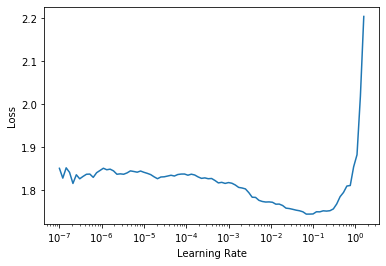

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.513907,1.464240,0.374700,01:22
1,1.476806,1.387539,0.390607,01:22
2,1.419699,1.344788,0.413332,01:21
3,1.349167,1.340858,0.427471,01:20
4,1.315611,1.335209,0.432521,01:22


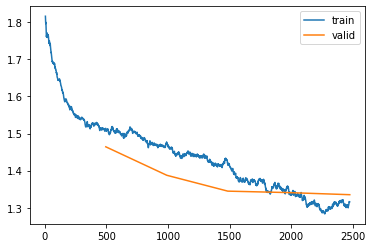

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.296991,1.341888,0.432269,01:21
1,1.297859,1.359076,0.429239,01:21
2,1.294858,1.342078,0.435299,01:21
3,1.262036,1.364397,0.427598,01:21
4,1.269845,1.349895,0.433405,01:21


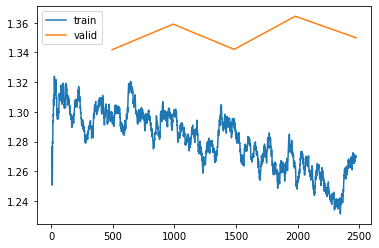

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.214339,1.327852,0.445651,01:57
1,1.077322,1.287853,0.481126,01:56
2,0.910342,1.304722,0.491605,01:53
3,0.770325,1.337228,0.498674,01:53
4,0.734901,1.351412,0.499558,01:53


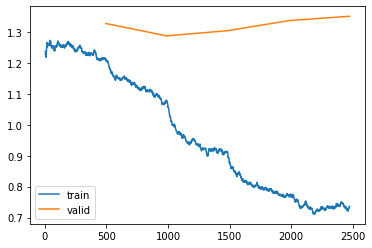

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.716003,1.396846,0.498296,01:57
1,0.682674,1.506487,0.505997,01:53
2,0.533026,1.554336,0.521273,01:53
3,0.445054,1.596647,0.521273,01:52
4,0.401137,1.620516,0.520389,01:55


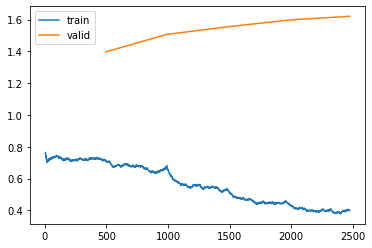

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_re_rating_classification")

In [0]:
learn.load(path/"first_re_rating_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxmaj area xxmaj business xxmaj unit ( abu ) \r\n and xxmaj individual xxmaj units \r\n xxmaj year \r\n xxmaj built \r\n xxmaj nominal \r\n xxmaj capacity \r\n xxmaj current \r\n xxmaj throughput \r\n xxmaj distillation & xxmaj reforming \r\n xxmaj no . 4 xxmaj crude / xxmaj vacuum 1976 245 , xxrep 3 0 b / d 245 , xxrep 3 0 b / d \r\n xxmaj no . 4 xxmaj rheniformer 1971 30 , xxrep 3 0 b / d 30 , xxrep 3 0 b / d \r\n xxmaj no . 5 xxmaj rheniformer 1976 32 , xxrep 3 0 b / d 32 , xxrep 3 0 b / d \r\n xxmaj no . 5 xxmaj naphtha xxmaj hydrotreater 1976 55 , xxrep 3 0 b / d 55 , xxrep 3 0 b / d \r\n xxmaj penhex xxmaj isomerization 1994 25 , xxrep",High,High
1,"xxbos xxmaj apparently , this company should depend on the sole product market ( pmma ) . xxmaj its 5 unit plants seem to be in operation as one production line . \r\n\r\n xxmaj from seen the risk information below , production lines are situated separately in the three locations - xxup m1 , xxup m2 / xxup m3 / xxup p2 , and xxup p1 - but , those are interconnected by pipe lines . xxup m2 may depend on xxup m1 to receive raw material ( mtbe ) . xxmaj all monomers produced from xxup m1 , xxup m2 and xxup m3 are stored in xxup m2 and then piped out to the xxup p1 and xxup p2 . \r\n\r\n\r\n xxup mma production \r\n\r\n "" the raw materials are xxup mtbe and methanol … xxmaj while all of the three xxup mma plants obtain methanol from one agency",Medium-High,Medium-High
2,"xxbos xxmaj steam \r\n xxmaj there are three small package boilers to supply process heating duty and maintenance / cleaning needs ( 15 , 12 and 9 tonnes / hour ) . xxmaj steam is raised at 46 and 32 barg and let down to lower working levels . \r\n xxmaj usually one boiler is operated and two on standby to meet xxmaj plant 1 ( 11 t / hr ) and xxmaj plant 2 ( 2 t / hr ) requirements , i.e. 100 % on - line redundancy . \r\n\r\n xxmaj electricity \r\n xxmaj power is supplied from the state - owned xxmaj taiwan xxmaj power xxmaj company . xxmaj there is a single incoming 69 kv underground feeder supplying five main substations that letdown 4.2 and 2.4 kv . xxmaj largest power users are the ethylene compressors in xxmaj plant 1 ( consumes 12 million xxunk /",Medium-High,Medium-High
3,"xxbos xxmaj controlling = > \r\n 1 ) xxmaj butanediol ( 1,4 butanediol ) from ally alcohol and syn gas = xxup mh \r\n 2 ) xxmaj phenol from cumene by peroxidation ( oxidation which forms hydrogen xxunk intermediate ) = xxup mh \r\n\r\n xxmaj the main petrochemical process units are shown as follows : \r\n • xxmaj phenol & xxmaj acetone = xxmaj propylene and xxmaj benzene are the major raw materials supplied by xxup cpc vis pipelines . xxmaj the phenol plant includes xxmaj cumene process unit and oxidation , concentration , decomposition & neutralization , purification and recovery process . xxmaj this licensor is xxup uop . \r\n • 1,4-butanediol xxmaj plant ( bdo 2 & xxup bdo 6 ) = xxmaj hydrogen gas is supplied from xxup cpc via pipeline . xxmaj allyl alcohol is supplied from xxup dcc xxup aal plant . xxmaj the reaction",Medium-High,Medium-High
4,"xxbos 2016 \r\n\r\n xxmaj there is a full inventory of spares for all large rotating equipment including rotors , bearings and seals - there are sufficient spares kept on site to perform a full overhaul . xxmaj rotors are rotated between spare and duty at t / a and the ex - duty rotor sent for overhaul . \r\n\r\n xxmaj there is a spare seal on site for all pumps and seal types . \r\n\r\n xxmaj the olefins plants have large turbo machines in cracked gas and refrigeration services . xxmaj these have driver outputs up to 25mw and are driven by 120bar steam turbines . xxmaj the large machines are not duplicated and are critical to production . xxmaj they have installed automatic protection ( bently xxmaj nevada ) for vibration and axial displacement . \r\n\r\r\n xxmaj the xxmaj utilities / xxmaj power xxmaj station has two steam turbo",Medium,Medium
5,"xxbos xxup

In [0]:
learn.validate()

(#2) [1.6205159425735474,0.5203888416290283]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

NameError: ignored

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

#Classification for PE+RE: label only

For classification, we need to use two set of transforms: one to numericalize the texts and the other to encode the labels as categories.

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(109889, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
1575,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, stream, plant, .]"
1576,Process flow configuration,RE,3,Medium-High,20,"[xxbos, xxmaj, single, train, process]"
1577,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, totally, single, train]"
1578,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, xxup, cdu, ,, xxup, vdu, ,, xxup, fcc]"
1579,Process flow configuration,RE,1,Low-Medium,20,"[xxbos, xxmaj, two, processing, units]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#87912) [45919,32709,9800,99217,44485,49396,80268,84567,51623,96892...],
 (#21977) [10773,21321,97123,66413,5636,43986,96783,67396,28700,33912...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("label"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj the plant has been operating at near or higher than design capacity during the previous years . xxmaj pre - revamp , the design capacity for the cracker ( for 476 ktpa ethylene ) was about 190 tonnes / hour of naphtha feed , while the site had operated in the range of 190 – 220 tonnes / hour rate . xxmaj the site claims that the design capacity had inbuilt margins and the plant was operated at higher capacity after receiving approval from the licensors . xxmaj for the post - revamp case , the design naphtha feed rate is 257 tonnes / hour , while the plant is currently operating at about 250 tonnes / hour with one heater still under reconstruction ( post 2009 fire ) . \r\n\r\n xxmaj following is the unit - wise operating capacity figures for 2008 to till date . \r\n\r\n",Mode of operation
1,"xxbos xxmaj jetty \r\n xxmaj the xxmaj port xxmaj arthur xxmaj terminal , two miles south of the site , has three berths , which are used to export products and import intermediates , such as gasoline blend stocks , diesel , fuel oil , xxup vgo and coker feed , and lubes . \r\n\r\n xxmaj the xxmaj port xxmaj arthur xxmaj terminal docks have concrete and steel berths . xxmaj connections use flexible hoses , with insulating flanges provided on the manifold . xxmaj remote isolation facilities are available for all pipelines to the xxmaj terminal . \r\n\r\n xxmaj road and xxmaj rail \r\n xxmaj smaller product quantities are dispatched by road and rail . xxmaj rail facilities are now only used for export of lube oils , petroleum coke , and caustic . \r\n\r\n xxmaj liquid sulfur is loaded into trucks for transport to a terminal in south",Loading / Unloading / Shipping


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

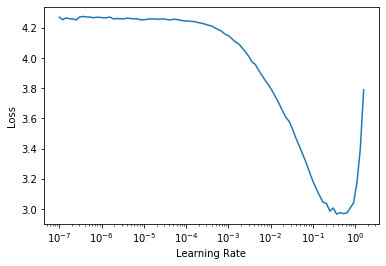

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 5e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.829731,9.475003,0.563771,03:01
1,4.442895,10.252830,0.593575,03:00
2,1.812277,9.004614,0.718751,02:56
3,0.868765,0.688365,0.821859,03:00
4,0.618629,0.495607,0.862038,03:02


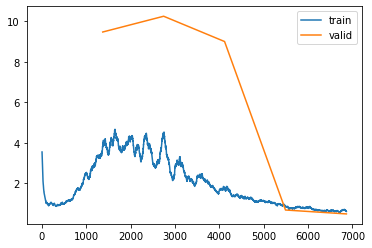

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.614675,0.490364,0.860263,03:03
1,0.599012,0.498761,0.859626,03:03
2,0.531587,0.486687,0.866269,03:04
3,0.597423,0.475922,0.867316,03:04
4,0.565252,0.482895,0.866952,03:07


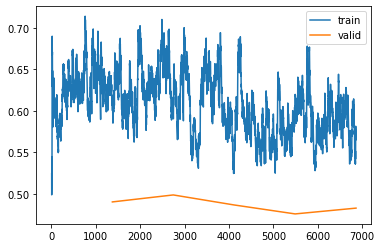

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.489105,0.433799,0.878646,05:04
1,0.353830,0.404564,0.887291,05:07
2,0.280178,0.401126,0.892433,05:03
3,0.216742,0.420113,0.894708,05:01
4,0.173867,0.430152,0.894981,05:08


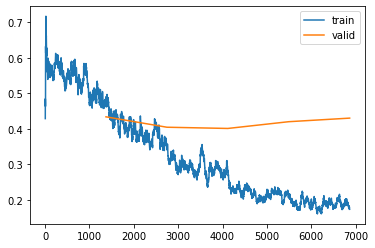

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_repe_label_classification")

In [0]:
learn.load(path/"first_repe_label_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos xxunk risk visit : \r\n xxmaj changed from med - high to xxmaj high considering the bottlenecks . \r\n xxmaj in the plant about 4 days storage is maintained . xxmaj this is in addition to the storage at xxup cot . \r\n xxmaj concern with single xxup sbm was discussed . \r\n 60 - 70 % of crude is purchased on long term basis and balance is on spot purchase . \r\n\r\n 2013 desktop assessment : \r\n xxmaj there is a single xxup sbm , single pipeline , but 15 days storage ; also plant located 1 xxrep 3 0 + km away from the port . \r\n\r\n xxmaj the crude will arrive via vlccs to the xxup sbm unloading buoy in xxmaj mundra in xxmaj xxunk state , xxmaj west xxmaj india and then be transported to the xxmaj crude xxmaj oil xxmaj terminal ( cot )",Raw materials and products,Raw materials and products
1,"xxbos 2015 : \r\n 10.02 xxmaj firewater xxmaj network xxmaj enhancements = > xxmaj closed = > xxmaj site fire water hydraulic modelling study was completed by xxup eob . a number of upgrades have been done to the firewater system on site as a result of this modelling work , including the installation additional firewater pumps and elevated monitors on the xxmaj no.2 xxmaj dock . \r\n\r\n 2013 : \r\n xxmaj the complex is protected by a combined 24 inch / 18 inch fire water / process water system . \r\n 12 - 08 - 003 xxmaj improve the fire water distribution system \r\n 11 - 04 - 001 xxmaj review deluge demand flows along with unit drainage to determine maximum water demands . \r\n\r\n xxmaj name xxmaj pump \t\t xxmaj type xxmaj driver xxmaj type \t\t\t xxmaj flow ( gpm ) \t xxmaj pressure ( psi ) \r\n",Fire water supply,Fire water supply
2,"xxbos xxmaj last year a major organisational change was undertaken where the maintenance was separated from maintenance . i expect this change to take some time to reach a stable phase . xxmaj there may be ownership issues as of now . a new safety engineer is on - board now . \r\n\r\n xxmaj turnover in the past was consistently around 15 - 20 per year . ( 2011 broker report - current stats not known ) \r\n\r\n xxmaj this refinery was originally constructed by xxmaj pontiac xxmaj refining xxmaj company in 1935 . xxmaj it operated for 25 years under its ownership , at a throughput of 25 , xxrep 3 0 bpd with a xxmaj crude xxmaj unit , xxmaj cat xxmaj cracker , xxup btx , and xxmaj alky xxmaj units . xxmaj the small xxup fcc and xxup btx units are still in operation as of",Organisational change history,Organisational change history
3,"xxbos xxmaj the inlet gas comes from xxmaj atlas ’ own gathering system . xxmaj this system generally stretches from near xxmaj xxunk , xxup ok xxmaj southeast to near xxmaj xxunk , xxup tx and has several hundred wells feeding it . xxmaj there are six pipelines supplying the plant . xxmaj four are low - pressure pipelines ( 2 - 3 psig ) including xxmaj east xxup lp ( ~12 xxup mmscf / xxup d ) , xxmaj west xxup lp ( ~12 xxup mmscf / xxup d ) , xxmaj xxunk and xxmaj sour xxmaj gas . xxmaj the other two pipelines are high - pressure lines at about 750 psig , which is the plant ’s operating pressure . xxmaj these pipelines \r\n are the xxmaj east xxmaj xxunk and xxup xxunk ( xxunk xxmaj to xxmaj velma ) pipelines . \r\n\r\n▁ xxmaj the high -",Raw materials and products,Raw materials and products
4,"xxbos xxmaj the plant process is designed to process 92 xxup mmcfd of natural gas in one - process trains . xxmaj the plant is currently operating at 93 % utilization , producing over 2 xxrep 3 0 bbl / day of xxup ngl , xxunk of xxup co2 , and 6 xxup mmcfd of natural gas , used as fuel gas on site and sold to xxmaj wasson xxup co2 xxmaj recovery xxmaj plant . \r\n\r\n xxunk casing head gas from xxmaj willard and other outside producing fields is gathered and fed to the plant , where it is boosted from 65 psig to 350 psig by inlet compressors . \r\n\r\n xxmaj this wet , sour gas is then dehydrated in a xxup teg unit to a -25 degree f dew point and fed

In [0]:
learn.validate()

(#2) [0.4301518201828003,0.8949811458587646]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

('Gas detection, fire and smoke detection measures',
 tensor(21),
 tensor([3.4738e-10, 4.1547e-12, 3.7439e-13, 9.5166e-09, 1.3815e-09, 6.6814e-11,
         5.1415e-09, 3.4518e-12, 2.5945e-10, 6.6652e-11, 1.4535e-12, 2.5147e-11,
         1.3821e-08, 1.2601e-10, 7.3556e-10, 1.2996e-11, 1.1874e-09, 1.8781e-11,
         1.2161e-11, 4.1454e-09, 4.4984e-12, 1.0000e+00, 4.1587e-09, 6.1885e-10,
         1.4901e-09, 7.7990e-11, 1.0546e-09, 2.0796e-09, 6.2986e-09, 3.3518e-11,
         3.7322e-14, 9.4247e-10, 3.9760e-13, 1.4052e-09, 1.3940e-12, 2.2248e-12,
         8.3463e-12, 4.4350e-13, 3.2822e-08, 2.6009e-09, 1.0762e-11, 5.1886e-10,
         1.3089e-13, 8.4069e-12, 8.6151e-12, 3.0518e-11, 1.9991e-10, 4.9099e-10,
         1.2435e-11, 7.1862e-14, 6.9185e-12, 1.7899e-11, 1.8835e-11, 9.8642e-12,
         3.1148e-10]))

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

'Gas detection, fire and smoke detection measures'

#Classification between PE and RE

For classification, we need to use two set of transforms: one to numericalize the texts and the other to encode the labels as categories.

In [0]:
df_cls = df_tok[(df_tok.length <= 2000) & (df_tok.length >=20)] 
df_cls.shape

(109889, 6)

In [0]:
df_cls.head()

,label,type,score,rating,length,text
1575,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, stream, plant, .]"
1576,Process flow configuration,RE,3,Medium-High,20,"[xxbos, xxmaj, single, train, process]"
1577,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, totally, single, train]"
1578,Process flow configuration,RE,4,High,20,"[xxbos, xxmaj, single, xxup, cdu, ,, xxup, vdu, ,, xxup, fcc]"
1579,Process flow configuration,RE,1,Low-Medium,20,"[xxbos, xxmaj, two, processing, units]"


In [0]:
splits = RandomSplitter()(range_of(df_cls))

In [0]:
splits

((#87912) [45919,32709,9800,99217,44485,49396,80268,84567,51623,96892...],
 (#21977) [10773,21321,97123,66413,5636,43986,96783,67396,28700,33912...])

In [0]:
dsrc = DataSource(df_cls, splits=splits, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("type"), Categorize()]], dl_type=SortedDL)

We opnce again use a subclass of `TfmdDL` for the dataloaders, since we want to sort the texts (sortish for the training set) by order of lengths. We also use `pad_collate` to create batches form texts of different lengths.

In [0]:
dbunch = dsrc.databunch(before_batch=pad_input, after_batch=Cuda, bs =64)

In [0]:
dbunch.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj apparently , this company should depend on the sole product market ( pmma ) . xxmaj its 5 unit plants seem to be in operation as one production line . \r\n\r\n xxmaj from seen the risk information below , production lines are situated separately in the three locations - xxup m1 , xxup m2 / xxup m3 / xxup p2 , and xxup p1 - but , those are interconnected by pipe lines . xxup m2 may depend on xxup m1 to receive raw material ( mtbe ) . xxmaj all monomers produced from xxup m1 , xxup m2 and xxup m3 are stored in xxup m2 and then piped out to the xxup p1 and xxup p2 . \r\n\r\n\r\n xxup mma production \r\n\r\n "" the raw materials are xxup mtbe and methanol … xxmaj while all of the three xxup mma plants obtain methanol from one agency",RE
1,"xxbos 2016 xxmaj visit : \r\n xxmaj jetty has manually operated monitors . xxmaj deluge valve can be remotely activated . \r\n\r\n xxmaj foam is tested annually . xxmaj two types of foam are used - 1 % and 3 % . \r\n\r\n xxmaj observation : xxmaj hydrocracker and xxmaj old xxmaj platformer areas – suggest reviewing fire hydrant philosophy / locations from an xxmaj emergency xxmaj services response perspective ( including line of sight monitor installations for higher hazard areas ) . \r\n\r\n 2016 : \r\n xxmaj mobile fire fighting equipment at the refinery includes : \r\n\r\n xxmaj fire 224 xxmaj heavy xxmaj pump , xxmaj foam xxmaj tender , xxmaj aerial xxmaj appliance . 20 m hydraulic boom with 5700 xxmaj lt / min xxmaj monitor , 7600 xxmaj lt / min water pump , xxmaj xxunk foam system , 4,500 litres foam concentrate . \r\n xxmaj fire",PE


Then we once again have a convenience function to create a classifier from this `DataBunch` with the `AWD_LSTM` architecture.

In [0]:
learn = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.1)

In [0]:
learn = learn.load_encoder(path/'fine_tuned_enc')

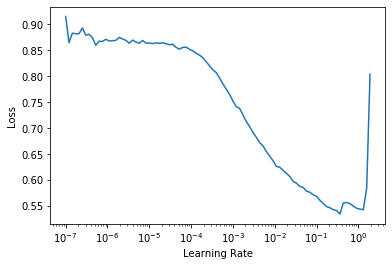

In [0]:
learn.lr_find()

Then we can train with gradual unfreezing and differential learning rates.

In [0]:
learn.fit_one_cycle(5, 5e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.512175,0.376574,0.937753,03:02
1,0.510596,0.180876,0.941257,03:02
2,0.573543,0.272425,0.930063,03:04
3,0.337403,0.302807,0.943168,03:03
4,0.281182,0.183356,0.947081,03:03


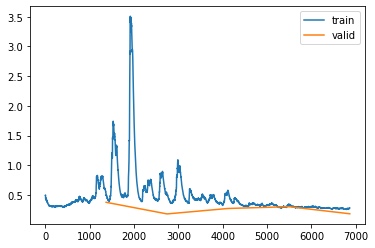

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.292991,0.146376,0.946353,03:05
1,0.298351,0.162227,0.945488,03:05
2,0.273184,0.153854,0.947991,03:05
3,0.275655,0.145766,0.947900,03:08
4,0.270863,0.143088,0.947764,03:07


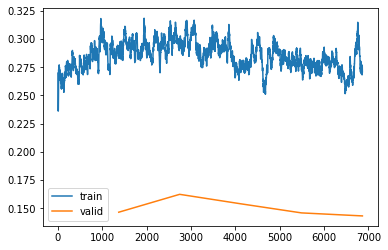

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.142656,0.113945,0.959867,05:07
1,0.079752,0.092608,0.967557,05:11
2,0.051588,0.101642,0.969059,05:10
3,0.038484,0.114620,0.969468,05:04
4,0.023138,0.116291,0.969787,05:14


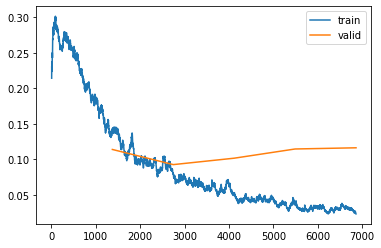

In [0]:
learn.recorder.plot_loss()

In [0]:
learn.save(path/"first_repe_classification")

In [0]:
learn.load(path/"first_repe_classification")

In [0]:
learn.show_results(max_n=10)

,text,category,category_
0,"xxbos 2015 : \r\n xxmaj retain xxup aa \r\n xxup scor 12.3 xxmaj positive xxmaj pressure xxmaj control of xxmaj control and xxmaj technical xxmaj rooms = > operators have no means to detect a loss of positive pressure in case of failure of ventilation or doors left open . \r\n\r\n 2011 : \r\n xxmaj there are 9 separate control rooms operating independently in terms of xxup dcs operation at the site . xxmaj the xxmaj central xxmaj control xxmaj room building ( for xxup ncu control ) is located about 100 m north of the nearest process unit xxup bdeu and about 170 m north east of the xxup ncu . xxmaj the building is of concrete construction , apparently designed for 5 psi overpressure . xxmaj doors , while shielded from direct blast via concrete wall are of glass . xxmaj considering the safe distance , the current",PE,PE
1,"xxbos xxunk risk visit : \r\n xxmaj changed from med - high to xxmaj high considering the bottlenecks . \r\n xxmaj in the plant about 4 days storage is maintained . xxmaj this is in addition to the storage at xxup cot . \r\n xxmaj concern with single xxup sbm was discussed . \r\n 60 - 70 % of crude is purchased on long term basis and balance is on spot purchase . \r\n\r\n 2013 desktop assessment : \r\n xxmaj there is a single xxup sbm , single pipeline , but 15 days storage ; also plant located 1 xxrep 3 0 + km away from the port . \r\n\r\n xxmaj the crude will arrive via vlccs to the xxup sbm unloading buoy in xxmaj mundra in xxmaj xxunk state , xxmaj west xxmaj india and then be transported to the xxmaj crude xxmaj oil xxmaj terminal ( cot )",RE,RE
2,"xxbos 2015 : \r\n xxmaj changed from xxup lm to m as no clarity on spare rotors . \r\n xxmaj there are no defined levels of spares – they are based on operational experience . xxmaj however there is a critical spare list . \r\n xxmaj there is an xxunk understanding between xxup pll and xxmaj hazira xxup lng ( shell / xxmaj total xxup jv ) for assisting each other with spares if requested . \r\n a spare xxup hp gas export pump is kept in stock at site . xxmaj this is used to allow quick changeover of a pump to allow inspection offline . \r\n xxup bog compressors are specialist manufacture , with a lead replacement time of at least 1 year . xxmaj manufacturer is xxmaj dresser xxmaj rand ; with phase 1 and 2 compressors manufactured in xxmaj france ; but phase 3 compressors will",RE,RE
3,"xxbos xxmaj electrical : \r\n xxmaj normal plant electrical demand is approximately 39 xxup mw . xxmaj the xxmaj cogen has two 38 xxup mw xxup ge frame 6b gas turbine generators and two 12 xxup mw steam turbine generators . xxmaj the utility department typically needs to operate one of the two gas turbines and a steam turbine to supply the entire plant demand . xxmaj the excess power generated ( 6 to 7 xxup mw ) is sold back to the local public utility company , xxmaj entergy . \r\n\r\n xxmaj the xxmaj utilities xxmaj unit is connected to the xxmaj entergy power grid through a xxmaj formosa owned substation and has the ability to buy from or sell to the grid . xxmaj while the site can run in island mode , it could not be answered as to whether or not the site could run completely",RE,RE
4,"xxbos conocophillips is a xxunk % joint venture partner in the bayu - undan xxmaj offshore xxmaj development xxmaj project , which supplies 100 % of the gas feed to the xxmaj darwin plant . xxmaj the bayu - undan field is located in the xxmaj timor xxmaj sea , approximately 250 km ( 155 mi ) southeast of xxmaj xxunk , timor - xxunk ( see xxmaj figure 3 ) . a 26-inch 500 km ( 310 mi ) sub - sea pipeline delivers dry natural gas from the bayu - undan production facilities to the plant . \r\n\r\n xxmaj the upstream xxmaj business xxmaj interruption xxmaj interdependency ( bii ) exposures at xxmaj darwin are significant . xxmaj the bayu - undan xxmaj offshore xxmaj development xxmaj project supplies 100 % of the natural gas feed to the xxmaj darwin plant ( ~750 mmscfd ) 

In [0]:
learn.validate()

(#2) [0.1162906140089035,0.9697865843772888]

In [0]:
input_str = "Hydrocarbon gas detectors is adequate"

In [0]:
input_tok = tokenize1(input_str)
input_df = pd.DataFrame({'text':[input_tok]})
predict(learn, input_df)

('PE', tensor(0), tensor([9.9999e-01, 1.1175e-05]))

In [0]:
input_num = dsrc.tfms[0][1](input_tok).cuda()
pred      = learn.model(input_num.unsqueeze(0))[0].squeeze()
pred_cat  = dsrc.tfms[1][1].decode(pred.argmax()); pred_cat

'PE'

#Prediction

In [0]:
#pd.DataFrame({'comb_rating':list(df_cls.comb_rating.unique())*3, 'text':["sample"]*156*3}).to_csv(path/'clas_cats.csv')
#pd.DataFrame({"vocab":vocab}).to_csv(path/"vocab.csv")
df_temp =pd.read_csv(path/'clas_cats.csv')
splits_temp = [range_of(df_temp)[0:300],range_of(df_temp)[300:len(df_temp)]]
dsrc_temp = DataSource(df_temp, splits=splits_temp, tfms=[
    [attrgetter("text"), Numericalize(vocab)],
    [attrgetter("comb_rating"), Categorize()]], dl_type=SortedDL)
dbunch_temp = dsrc_temp.databunch(before_batch=pad_input, after_batch=Cuda)
learn_temp = text_classifier_learner(dbunch, AWD_LSTM, metrics=[accuracy], path=path, opt_func=Adam, drop_mult=0.5)
learn_temp = learn.load_encoder(path/'fine_tuned_enc')
learn_temp.load(path/"first")